<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - ANÁLISE DO DATASET E SUAS CARACTERÍSTICAS

Códigos para importação do conjunto de dados, para determinação do número de amostras, de preditores e quais serão as classes analisadas.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('_mpl-gallery')
plt.rcParams.update({'font.size': 30})
url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)

# We can remove "year", "month" and "day" columns,
# since we did no time series analysis today...
# "VG" is removed, we do not have any info about
df = df.drop(['SLP', 'VG', 'year', 'month', 'day'], axis=1)

# Information about our data set
print('Number of Observations (N): ', df.shape[0])
print('Number of Predictor Variables (D): ', df.shape[1])

# Q diabos é isso abaix kaique??? Why?
print(df['COD'].describe())
print(df['BOD'].describe())

Number of Observations (N):  1382
Number of Predictor Variables (D):  15
count    1382.000000
mean      845.960434
std       145.416540
min       360.000000
25%       751.250000
50%       845.000000
75%       920.000000
max      1700.000000
Name: COD, dtype: float64
count    1382.000000
mean      382.061708
std        85.996012
min       140.000000
25%       330.000000
50%       360.000000
75%       422.980000
max       850.000000
Name: BOD, dtype: float64


## 1.1 - **Classes**

Como indicadores de economia/deseperdicio durante o tratamento, utilizaremos as métricas COD e BOD, que respectivamente significam Chemical Oxygen Demand (mg/L) e Biological Oxygen Demand (mg/L).\
\
Dessa forma, podemos dividir o intervalo desses indicadores em n partes, utilizando-as como classificação.\
\
A Chemical Oxygen Demand(COD), indica a quantidade de oxigênio utilizado durante a reação quimica para consumir contaminantes presentes. \
Já a Biological Oxygen Demand(BOD), é a unidade de medida utilizada para determinar a quantidade de oxigênio utilizado por organismos biológicos aeróbicos. \
Com os dois indicativos construiremos classes formadas da combinação dos dois intervalos criados pela média de COD e de BOD. \
\
Iremos dividir os nossos dados em 3 intervalos para cada um dos seguintes preditores:\
COD:\
  Baixo: 360 - 790;\
  Medio: 791 - 890;\
  Alto: 891 - 1700.\
\
BOD:\
  Baixo 140 - 340;\
  Medio: 341 - 400;\
  Alto : 401 - 850.\
\
PP:\
  No_rain: <0.1;\
  Light_rain: 0.1 - 1;\
  Moderate_rain: >1;\
\
Tipo 1: Baixo - Baixo; Tipo 2: Baixo - Medio; Tipo 3 Baixo - Alto;\
Tipo 4: Medio - Baixo; Tipo 5: Medio - Medio; Tipo 6 Medio - Alto;\
Tipo 7: Alto - Baixo; Tipo 8: Alto - Medio; Tipo 9 Alto - Alto.

In [21]:
# Testing values - Marco

df_sorted3 = df['PP'].sort_values(ascending=False)
print(df_sorted3.head(75))


70     18.03
199    16.51
69     16.26
284    13.72
179    12.95
       ...  
160     0.51
155     0.51
239     0.51
103     0.51
266     0.51
Name: PP, Length: 75, dtype: float64


In [22]:
df_cod_baixo = df[(df['COD'] >=360) & (df['COD'] <= 790)]
df_cod_medio = df[(df['COD'] >=791) & (df['COD'] <= 890)]
df_cod_alto = df[(df['COD'] >=891) & (df['COD'] <= 1700)]

df_bod_baixo = df[(df['BOD'] >=140) & (df['BOD'] <= 340)]
df_bod_medio = df[(df['BOD'] >=341) & (df['BOD'] <= 400)]
df_bod_alto = df[(df['BOD'] >=401) & (df['BOD'] <= 850)]

df_no_rain = df[df['PP'] < 0.1]
df_light_rain = df[(df['PP'] >= 0.01) & (df['PP'] <= 1)]
df_moderate_rain = df[df['PP'] > 1]


tipo1 = pd.merge(df_cod_baixo, df_bod_baixo, how='inner')
tipo2 = pd.merge(df_cod_baixo, df_bod_medio, how='inner')
tipo3 = pd.merge(df_cod_baixo, df_bod_alto, how='inner')

tipo4 = pd.merge(df_cod_medio, df_bod_baixo, how='inner')
tipo5 = pd.merge(df_cod_medio, df_bod_medio, how='inner')
tipo6 = pd.merge(df_cod_medio, df_bod_alto, how='inner')

tipo7 = pd.merge(df_cod_alto, df_bod_baixo, how='inner')
tipo8 = pd.merge(df_cod_alto, df_bod_medio, how='inner')
tipo9 = pd.merge(df_cod_alto, df_bod_alto, how='inner')

tipos = [tipo1, tipo2, tipo3, tipo4, tipo5, tipo6, tipo7, tipo8, tipo9]

#for i, tipo in enumerate(tipos):
  #print(f"Type {i+1}: {tipo.shape[0]} rows\n", tipo.head(), "\n")

for i, tipo in enumerate(tipos):
    print(f"Tipo {i}: {tipo.shape[0]}")

Tipo 0: 262
Tipo 1: 204
Tipo 2: 29
Tipo 3: 128
Tipo 4: 93
Tipo 5: 194
Tipo 6: 110
Tipo 7: 129
Tipo 8: 232


In [23]:
df_class_BOD_COD = df[['COD','BOD']]
df = df.drop(['COD', 'BOD'], axis=1)

In [24]:
def analyze_dataset(df: pd.DataFrame):
    stats_analysis = pd.DataFrame(columns=['name', 'mean', 'std_deviation', 'skewness'])

    for index, predictor in enumerate(df.columns):
        stats_analysis.loc[index] = [predictor, df[predictor].mean().round(2), round(df[predictor].std(), 2), df[predictor].skew().round(2)]

    # For index starting at 1
    stats_analysis.index = stats_analysis.index + 1
    return stats_analysis

---
# 2 - ANÁLISE INCONDICIONAL MONOVARIADA

Análise de cada preditor individualmente. É a forma mais simples de analisar os dados

In [ ]:
generated_files = []

for i, predictor in enumerate(df.columns):
    fig, axs = plt.subplots(1, 2, figsize=(18,9))

    _, bins, _ = axs[0].hist(df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::4], title=f'{predictor} histogram')
    axs[1].boxplot(df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 1.0},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 1.0},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

    plt.tight_layout()

    filename = f'./img/plot_{predictor}.png'
    fig.savefig(filename, bbox_inches='tight')
    generated_files.append(filename)
    # plt.close(fig)

analyze_dataset(df)

In [ ]:
# Compactação dos arquivos para fazer o download
# !zip -r plots.zip ./img

---
# 3 - ANÁLISE **CONDICIONAL** MONOVARIADA
Descrever e investigar como os preditores distribuem-se entre as classes

## 3.1 - ANÁLISE DO KAIQUE

### 3.1.1 - CHEMICAL OXYGEN DEMAND (COD) BAIXO

In [ ]:
# Tipo1 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo1.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo1[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo1[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
analyze_dataset(tipo1)

### 3.1.2 - CHEMICAL OXYGEN DEMAND (COD) MÉDIO

In [ ]:
# Tipo2 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo2.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo2[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo2[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
analyze_dataset(tipo2)

### 3.1.3 - CHEMICAL OXYGEN DEMAND (COD) ALTO

In [ ]:
# Tipo3 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo3.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo3[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo3[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
analyze_dataset(tipo3)

### 3.1.4 - BIOLOGICAL OXYGEN DEMAND (BOD) BAIXO

In [ ]:
# Tipo4 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo4.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo4[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo4[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
analyze_dataset(tipo4)

### 3.1.5 - BIOLOGICAL OXYGEN DEMAND (BOD) MÉDIO

In [ ]:
# Tipo5 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo5.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo5[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo5[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
analyze_dataset(tipo5)

### 3.1.6 - BIOLOGICAL OXYGEN DEMAND (BOD) ALTO

In [ ]:
# Tipo6 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo6.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo6[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo6[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting6t 1
analyze_dataset(tipo6)

### 3.1.7 - SEM CHUVA

In [ ]:
# Tipo7 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo7.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo7[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo7[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting6t 1
analyze_dataset(tipo7)

### 3.1.8 - CHUVA LEVE

In [ ]:
# Tipo8 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo8.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo8[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo8[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting6t 1
analyze_dataset(tipo8)

### 3.1.9 - CHUVA MODERADA

In [ ]:
# Tipo9 - Analise Condicional do Kaique

for i, predictor in enumerate(tipo9.columns):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))

    _, bins, _ = axs[0].hist(tipo9[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(tipo9[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting6t 1
analyze_dataset(tipo9)

## 3.2 - ANÁLISE DO MARCO

In [ ]:
# No_rain analysis - Analise condicional do Marco

print(analyze_dataset(df_no_rain))

pairgrid = sns.pairplot(
    df_no_rain,
    height=1,
    aspect=1,
    plot_kws=dict(
        s=64,                 # marker size
        alpha=0.5,           # transparency
        marker='.',          # marker type ('o', '^', '.', 'x', etc.)
        edgecolor="blue",   # thin black edge (set to 'none' to disable)
        linewidth=0.1,
    )
)

for ax in pairgrid.axes.flatten():
    if ax is not None:
        ax.grid(False)
        ax.set_facecolor("white")

        # Remove tick marks and labels
        ax.set_xticks([])
        ax.set_yticks([])

pairgrid.fig.tight_layout(pad=0.2)
plt.show()

In [ ]:
# Light_rain analysis - Analise condicional do Marco

pairgrid = sns.pairplot(
    df_light_rain,
    height=1,
    aspect=1,
    plot_kws=dict(
        s=64,                 # marker size
        alpha=0.5,           # transparency
        marker='.',          # marker type ('o', '^', '.', 'x', etc.)
        edgecolor="blue",   # thin black edge (set to 'none' to disable)
        linewidth=0.1,
    )
)

for ax in pairgrid.axes.flatten():
    if ax is not None:
        ax.grid(False)
        ax.set_facecolor("white")

        # Remove tick marks and labels
        ax.set_xticks([])
        ax.set_yticks([])

pairgrid.fig.tight_layout(pad=0.2)
plt.show()

In [ ]:
# Moderate_rain analysis - Analise condicional do Marco

pairgrid = sns.pairplot(
    df_moderate_rain,
    height=1,
    aspect=1,
    plot_kws=dict(
        s=64,                 # marker size
        alpha=0.5,           # transparency
        marker='.',          # marker type ('o', '^', '.', 'x', etc.)
        edgecolor="blue",   # thin black edge (set to 'none' to disable)
        linewidth=0.1,
    )
)

for ax in pairgrid.axes.flatten():
    if ax is not None:
        ax.grid(False)
        ax.set_facecolor("white")

        # Remove tick marks and labels
        ax.set_xticks([])
        ax.set_yticks([])

pairgrid.fig.tight_layout(pad=0.2)
plt.show()

In [ ]:
print(analyze_dataset(df_no_rain), "\n")
print(analyze_dataset(df_light_rain), "\n")
print(analyze_dataset(df_moderate_rain), "\n")

# 4 - ANÁLISE INCONDICIONAL **BIVARIADA**

### Descrever e investigar como os preditores distribuem-se entre si


In [ ]:
# Unconditional bi-variate analysis of the predictors

pairgrid = sns.pairplot(
    df,
    height=1,
    aspect=1,
    plot_kws=dict(
        s=64,                # marker size
        alpha=0.4,           # transparency
        marker='.',          # marker type ('o', '^', '.', 'x', etc.)
        edgecolor="blue",    # thin black edge (set to 'none' to disable)
        linewidth=0.1,
    )
)

for ax in pairgrid.axes.flatten():
    if ax is not None:
        ax.grid(False)
        ax.set_facecolor("white")
        ax.set_xticks([])
        ax.set_yticks([])

pairgrid.fig.tight_layout(pad=0.2)
plt.show()

# 5 - PCA**

##Passos
1 - Padronização de dados\
2 - Matriz de Covariancia\
3 - Autovalores e Autovetores da matriz de Covariancia\
4 - Ordenação\
5 - Seleção

In [25]:
df_new = (df - df.mean())/df.std()
df_new

,avg_outflow,avg_inflow,total_grid,Am,TN,T,TM,Tm,H,PP,VV,V,VM
0,-0.805359,-1.331870,-2.224505,-1.574715,-0.661643,0.789723,0.643829,0.550295,-0.520057,0.996165,0.055040,1.039293,1.558419
1,-0.809428,-1.073462,-2.095295,-1.832394,-0.760214,0.382202,0.432465,0.485875,-0.038434,-0.166873,0.055040,-0.712176,-0.652075
2,-0.815939,-0.890076,-1.638490,0.357877,0.498805,0.326631,0.939739,-0.265700,-1.139286,0.024416,0.055040,1.739880,2.212106
3,-0.815939,-0.800466,-1.514590,-0.415160,0.072597,-0.080890,-0.088899,0.228192,-1.001679,-0.166873,0.055040,1.053304,0.302652
4,-0.824891,-0.494822,-1.620390,0.873235,0.797877,-0.303175,-0.201627,-0.437489,0.099172,-0.166873,0.055040,0.156552,-0.015590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.925628,0.145641,0.689483,-1.445875,-1.101572,-1.525739,-1.483902,-1.296432,-0.520057,-0.166873,0.055040,-0.712176,-1.133739
1378,1.588075,0.697189,0.409648,0.100198,-0.579594,-1.377549,-0.638446,-1.511168,0.511991,-0.166873,-0.557596,-0.838282,-0.815497
1379,0.575687,0.211632,0.734958,1.002074,0.352628,-0.988552,-0.638446,-1.511168,0.099172,-0.166873,0.055040,-0.193741,-0.815497
1380,1.173842,0.293600,0.930005,0.873235,-0.073299,-0.766267,-0.497537,-1.081696,0.099172,-0.166873,0.055040,0.338705,-0.015590


In [26]:
cov = df_new.cov();
cov

,avg_outflow,avg_inflow,total_grid,Am,TN,T,TM,Tm,H,PP,VV,V,VM
avg_outflow,1.000000,0.541923,0.167099,0.040590,-0.061951,-0.000163,0.006070,0.035516,-0.016560,-0.090001,-0.027635,-0.015406,-0.006319
avg_inflow,0.541923,1.000000,0.136211,-0.032709,-0.035827,0.098149,0.093073,0.140905,-0.040534,-0.100358,-0.031872,-0.025010,-0.012203
total_grid,0.167099,0.136211,1.000000,-0.133076,-0.167448,-0.266053,-0.245119,-0.222896,0.155245,-0.014242,0.007085,0.020656,0.017388
Am,0.040590,-0.032709,-0.133076,1.000000,0.342995,0.110000,0.099279,0.094802,-0.076970,-0.074313,-0.028647,-0.047966,-0.048622
TN,-0.061951,-0.035827,-0.167448,0.342995,1.000000,0.269751,0.259386,0.232274,-0.210108,-0.012618,-0.053080,-0.029228,0.006540
T,-0.000163,0.098149,-0.266053,0.110000,0.269751,1.000000,0.924944,0.890901,-0.553688,-0.004256,-0.122247,0.098620,0.219791
TM,0.006070,0.093073,-0.245119,0.099279,0.259386,0.924944,1.000000,0.759461,-0.533249,-0.003110,-0.120905,0.035349,0.199370
Tm,0.035516,0.140905,-0.222896,0.094802,0.232274,0.890901,0.759461,1.000000,-0.386078,0.030974,-0.090034,0.123755,0.181562
H,-0.016560,-0.040534,0.155245,-0.076970,-0.210108,-0.553688,-0.533249,-0.386078,1.000000,0.129048,0.107531,-0.254965,-0.315783
PP,-0.090001,-0.100358,-0.014242,-0.074313,-0.012618,-0.004256,-0.003110,0.030974,0.129048,1.000000,0.136877,-0.005207,0.034294


In [54]:
autovalores, autovetores= np.linalg.eig(cov)


#indice_ordenado = np.argsort(autovalores)[::-1]
#autoval_ord = autovalores[indice_ordenado]
#autovet_ord = autovetores[:, indice_ordenado]
#print(autoval_ord)
#print(autovet_ord)
print(autovalores)
print(autovetores)

[3.46995686 1.82666197 1.67222413 1.22200971 1.07707661 0.03523213
 0.13439264 0.2442697  0.43551688 0.79035156 0.87241469 0.57865875
 0.64123437]
[[ 7.49208404e-03  1.19783770e-02 -6.38898910e-01 -7.75835864e-02
  -2.26341415e-01  1.09545551e-02  1.18154861e-02 -8.16444702e-03
   6.69491784e-01  2.11853859e-01  6.28081402e-03  2.02039884e-01
   8.47260722e-03]
 [ 5.72632162e-02 -1.32075358e-02 -6.45079097e-01  2.98335710e-02
  -1.64265758e-01  1.04596431e-02  1.08434281e-02  4.55366686e-02
  -6.77830535e-01  1.81435785e-01 -3.06321189e-02 -1.63642957e-01
   1.73652148e-01]
 [-1.79957465e-01  1.92260714e-01 -2.94958703e-01  2.31278908e-02
   1.48137068e-02  1.03097556e-02  2.29794980e-02 -1.88521816e-02
  -1.65236125e-02 -8.27033276e-01  3.70724333e-01  1.75241452e-03
  -1.42160899e-01]
 [ 1.03273415e-01 -2.34637977e-01  6.99415509e-02 -5.89269192e-01
  -3.81217204e-01 -3.42917588e-03 -4.40815171e-03  1.64369824e-02
  -1.80752008e-01  2.33575190e-02  9.25921227e-02  1.75884904e-01
  -6

In [66]:
#Toericamente não precisa fazer isso aqui, posso só pegar os 2 maiores autovalore, mas eu fiz por curiosidade

variancia_total = np.sum(autovalores)
variancia_exp = autovalores/variancia_total

print(variancia_exp)

vet_maiores = (autovetores[0], autovetores[1])

[0.26691976 0.14051246 0.12863263 0.09400075 0.08285205 0.06710882
 0.06079627 0.04932572 0.04451221 0.0335013  0.01878998 0.0103379
 0.00271016]


[3.46995686 1.82666197 1.67222413 1.22200971 1.07707661 0.87241469
 0.79035156 0.64123437 0.57865875 0.43551688 0.2442697  0.13439264
 0.03523213]


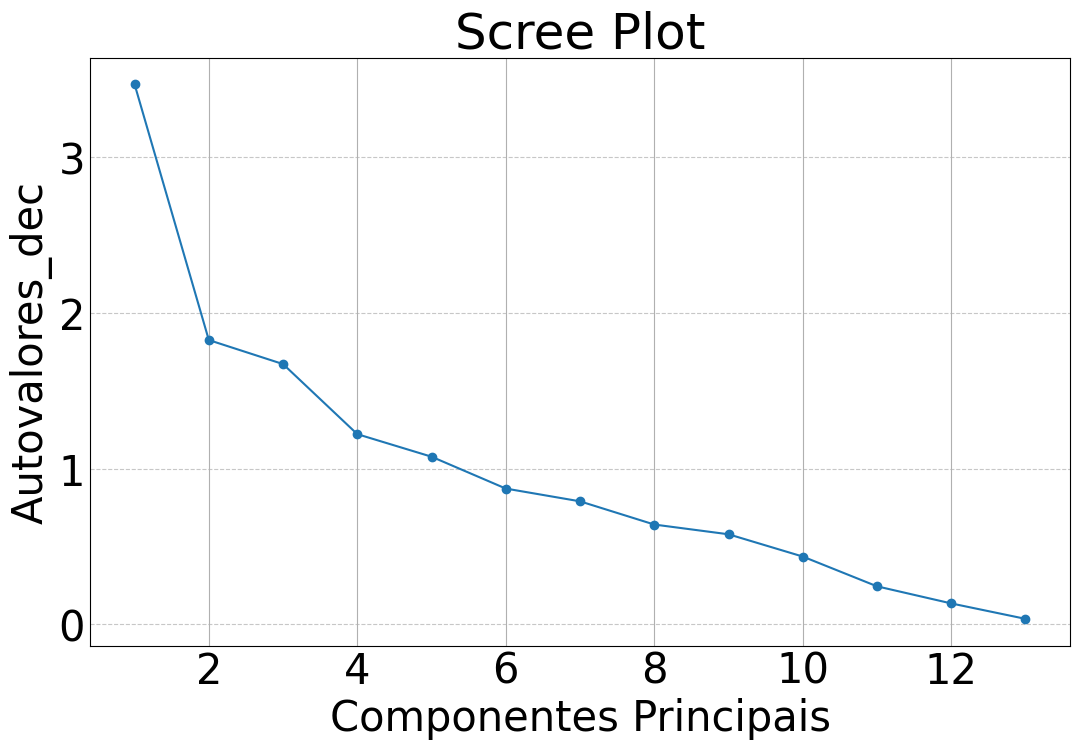

In [65]:
#screeplots
autovalores_dec = np.sort(autovalores)[::-1]
print(autovalores_dec)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autovalores_dec) + 1), autovalores_dec, marker='o', label='Autovalores_dec')
plt.xlabel('Componentes Principais')
plt.ylabel('Autovalores_dec')
plt.title('Scree Plot')
plt.grid(axis='y', linestyle='--', alpha=0.7)


O documento solicita somente os dois principais componentes

In [70]:
pca_df = np.matmul(vet_maiores,np.transpose(df_new))
pca_df = np.transpose(pca_df)
pca_df

,0,1
0,1.769337,2.140575
1,1.429169,1.417879
2,0.519284,1.826640
3,0.473697,1.452345
4,0.835571,0.746777
...,...,...
1377,-0.630660,-0.106746
1378,-0.000715,-0.539147
1379,-0.640974,-0.767134
1380,-0.538779,-0.718480
